# CSCI 3202, Spring 2020

# Wednesday 12 February 2020

# In-class notebook:  Hill climbing and Simulated Annealing



<br>

### Your name(s):

<br>

* When you submit this to Moodle, be sure to include all of your group members' names.
* You may work in groups of up to 3 people,
* but **all people** in the group must submit the assignment on their own Moodle account.

---

---

Before we begin, let's load a few packages that we might find useful.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

<br>

<img src="http://1.bp.blogspot.com/-mWUxSF7q_JY/Vbd84OcwaSI/AAAAAAAA7No/5iT8gMZBHw8/s1600/seilschaft2---helliventures-joachimhellinger.jpg=" width="300"/>



## Problem 1: Hill-climbing

The over-arching goal here is to maximize some objective function.  You can also look at this as minimizing some kind of a loss... and you will!

In many applications, the objective function might turn out to be a Gaussian function, such as this one:

In [2]:
def gaussian_objective(state):
    return stats.norm.pdf(x=state, loc=5, scale=2)

Note the this objective function is just taking in some value $\texttt{state}$ and returning the value of the normal probability density function, centered at $\texttt{loc} = \mu = 5$ and with standard deviation $\texttt{scale} = \sigma = 2$:
$$f(\texttt{state}) = \dfrac{1}{\sqrt{2\pi}\sigma} e^{-\dfrac{(\texttt{state}-\mu)^2}{2\sigma^2}}$$

For good measure, let's plot this thing up and see what it looks like.

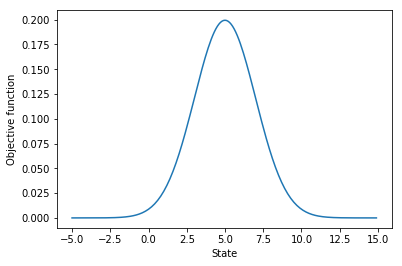

In [3]:
x = np.arange(-5,15,0.1)
f = [gaussian_objective(state) for state in x]

plt.plot(x,f)
plt.xlabel('State')
plt.ylabel('Objective function')
plt.show()

Neat.

<br>

The first order of business if we want to maximize some objective function using the **local search** techniques we just learned will be to set up a class structure to make this easier.

If we do this in a general enough way for **hill-climbing** (this first part), we will only need to modify a few things to tackle a trickier problem using **simulated annealing**.

<a/ id='p1a'></a>

### (1a)  A class structure to solve problems

So first, let's define a class to keep track of the `state`.  This is the quantity we want to adjust in order to optimize the objective function.  That sentence indicates the two values we really need to keep track of for a `state`:
1. the value of `state`
2. the value of the `objective_function` when evaluated at `state`

In [4]:
class state:

    def __init__(self, node, value):
        self.node = node
        self.value = value    

Now we need to define our problem.  This should be entirely self-contained, so that we need to feed the `hill_climb` optimization routine below a fairly generic problem description, and it can solve it, so we can easily feed in different problems.

**The goal** with this class structure is to have everything that is **problem-specific** sent into the hill-climbing optimization/local search be self-contained within the `problem` object.

In [5]:
class problem:
    
    def __init__(self, initial, objective_function, stepsize):
        self.initial_state = initial
        self.current_state = initial
        self.objective_function = objective_function
        self.stepsize = stepsize
        
    def moves(self):
        '''return all possible moves to make from the current_state'''
        all_moves = []
        # could move right...
        all_moves.append(self.current_state.node + self.stepsize)
        # ... or left!
        all_moves.append(self.current_state.node - self.stepsize)
        return all_moves

Finally, we can turn our Hill-climbing pseudocode into real code, that takes only two arguments and returns the `state` that optimizes the `objective_function`.  Note that the return can be done implicitly by manipulating the current state within our `problem`, or we could code it up as an explicit output.

In [6]:
def hill_climb(problem, n_iter):
    
    # iterate until we can't do any better
    for k in range(n_iter):
        nextMove, nextValue = problem.best_move()
        if nextValue <= problem.current_state.value:
            return problem.current_state
        #print(problem.current_state, nextMove)
        problem.current_state.node, problem.current_state.value = nextMove, nextValue
    print('reached n_iter')
    return False

class problem_hillclimb(problem):
    
    def best_move(self):
        '''return the best move possible from the current_state'''
        # what moves are possible?
        all_moves = self.moves()
        # what is objective function for each of them?
        obj_func = [self.objective_function(move) for move in all_moves]
        best = all_moves[max(zip(obj_func, range(len(obj_func))))[1]]
        return best, np.max(obj_func)



### (1b)  Ready to solve!

Let's start by creating an `initial_state` for our problem.

In [7]:
initial_state = state(node=1, value=gaussian_objective(1))

Now we need an instance of our `problem`.

In [8]:
gaussian_problem = problem_hillclimb(initial=initial_state, objective_function=gaussian_objective, stepsize=0.1)

Finally, we can turn out `hill_climb` algorithm loose on this problem.

In [9]:
out = hill_climb(gaussian_problem, n_iter=50)
print(out.node, out.value)

4.999999999999999 0.19947114020071635


## A couple extensions

That's good and all, but that particular objective function was just a single univariate Gaussian.  It turns out that the real world is tougher than that.  So let's tackle some tougher problems, shall we?



### (1c) Minimization

First, it might be the case that we want to ***minimize*** an objective function instead of maximizing it.  Modify your hill-climbing codes to tackle the problem of minimization.  Note:  this ought to be do-able by modifying a single line of code from above...

Now **define your own** objective function to minimize!  Easy options include concave-up quadratic functions just slapping a $-$ sign into the Gaussian objective function defined above.  Then turn your descent algorithm loose on the minimization problem.


### (1d)  Random restarts

That single Gaussian actually covers many real-world applications of optimization and local search, but many other applications lead to "bumpier" objective functions.  Suppose you are trying to fit a model to noisy data, and suppose each of your data points has normally-distributed uncertainty.  Then the objective function you would like to minimize could take the form of the sum of several Gaussian distributions, like so:

$$f(\texttt{state}) = \dfrac{1}{\sqrt{2\pi}\sigma} \left(e^{-\dfrac{(\texttt{state}-\mu_0)^2}{2\sigma^2}} + 
e^{-\dfrac{(\texttt{state}-\mu_1)^2}{2\sigma^2}} + 
e^{-\dfrac{(\texttt{state}-\mu_2)^2}{2\sigma^2}} + 
e^{-\dfrac{(\texttt{state}-\mu_3)^2}{2\sigma^2}} + 
e^{-\dfrac{(\texttt{state}-\mu_4)^2}{2\sigma^2}}\right)$$

Here, $\mu_i$ denotes the data points you have, $\sigma$ is assumed to be an uncertainty shared by all of them, and $\texttt{state}$ is your model's output, which you want to fit through those data points.

If we let $\sigma=1$, $\mu_0 = 0$, $\mu_1 = 2.1$, $\mu_2 = 4$, $\mu_3 = 4$ and $\mu_4 = 8$, then we end up with the following objective function, `several_gaussian_objective(state)`:

In [10]:
def several_gaussian_objective(state):
    locs = [0,2.1,4,4,8] # centers of a bunch of normal distributions
    objective_value = 0
    # objective function is actually just the sum of a bunch of normal pdfs
    for loc in locs:
        objective_value += stats.norm.pdf(state, loc=loc, scale=1)
    return objective_value

Plot up this new objective function as a function of `state`.  What do you notice?  Will our "vanilla" hill-climbing routine successfully climb the hill and maximize this objective function for *any* initial state?

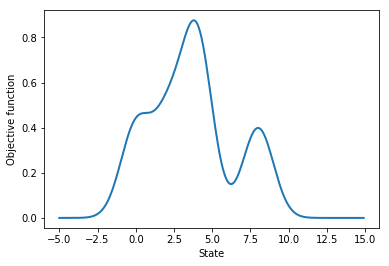

In [11]:
x = np.arange(start=-5, stop=15, step=0.1)
fx = [several_gaussian_objective(xk) for xk in x]
plt.plot(x, fx, lw=2)
plt.xlabel('State')
plt.ylabel('Objective function')
plt.show()

Note that we can check about where the global maximum is fairly easily:

In [12]:
max(zip(fx, x))

(0.8764853553213469, 3.7999999999999687)

Let's modify our vanilla hill-climbing solution approach from **(1b)** to include 500 random restarts for the initial state.

The following code will draw `n_restarts` random samples from the range $[0, 1)$.

In [13]:
n_restarts = 500
sample = np.random.random(size=n_restarts)

Modify that to draw instead from the range $[-2, 10)$.  Use those samples to create an **ensemble** of the values of `state` for which the objective function is maximized.  Plot a histogram of them, and make a conclusion about what the "best guess" for the maximal `state` is.

[ 7.67049437  4.94513505  0.91172221  4.5030828  -1.09547654  8.84553731
  1.96062916 -1.76272724  4.30088122  4.69595896]


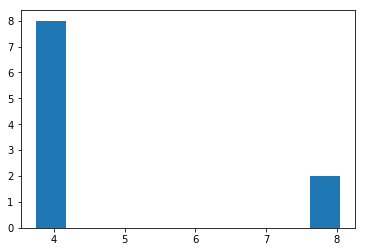

In [31]:
n_restarts = 10
max_found = []
range_init = [-2, 10]
initial_values = np.random.random(size=n_restarts)*np.diff(range_init)+range_init[0]
#initial_values = np.random.uniform(-2,10,size=n_restarts)
print(initial_values)

for n in range(n_restarts):
    initial_state = state(node=initial_values[n], value=several_gaussian_objective(initial_values[n]))
    gaussian_problem = problem_hillclimb(initial=initial_state, objective_function=several_gaussian_objective, stepsize=0.1)
    out = hill_climb(gaussian_problem, n_iter=500)
    max_found.append(out.node)
    
plt.hist(max_found)
plt.show()


### (1e) Final weird question

You probably noticed that a bunch of the random restarts landed at the global maximum near 4. That's good and makes perfect sense!

And you also probably noticed that a handful of them also landed near the local maximum just below 8. That is less good, but also makes sense.

But you may have also found a small bunch of simulations that ended up around 6.  That probably doesn't make immediate sense. **Why the heck** would any simulations end up around 6?  We're supposed to be ***hill-climbing***, and only taking uphill steps, and these are in a local minimum!

See if you can figure out what in the world is going on there.  It is subtle, but a critical point to be aware of whenever we try to solve a *continuous* problem with a *discrete* instrument (like a computer).

<br>

---

<br>

<img src="https://www.metalsupermarkets.com/wp-content/uploads/2015/09/Heat-Treating-Furnace-2.jpg" width="300"/>



## Problem 2: Simulated annealing



### (2a) 

First, we need to either create a new class for a simulated annealing `problem`, or sub-class our `problem` class from earlier. That shouldn't be too bad - the main difference is that instead of the best move at any given point, we need to select a random one.

In addition to the `objective_function` argument during construction, we also ought to include the `schedule_function` for the temperature updates as time goes on (which moderate how likely we are to take sub-optimal steps). (We will define that one next!)

In [15]:
class problem_anneal(problem):
#    def __init__(self, initial, objective_function, stepsize):

    def __init__(self, initial, objective_function, schedule_function, stepsize):
        problem.__init__(self, initial, objective_function, stepsize)
        self.schedule_function = schedule_function

    def random_move(self):
        '''return a random move, possible from the current_state'''
        all_moves = self.moves()
        next_move = np.random.choice(all_moves)
        return next_move, self.objective_function(next_move)

**Note** that here I've sub-classed `problem`. In general, it might make more sense to just add more methods to a generic problem class.


### (2b)  Find a temperature schedule

Now, we need to actually write our code for the simulated annealing algorithm.  That's a bit more involved than the hill-climbing.

The trickiest part is deciding the form for (1) the temperature/time schedule $T(t)$ ($T$ is temperature, $t$ is time), and (2) the accept/reject probability as a function of temperature and the difference in model performance between our current and proposed moves, $\Delta E$.

First, let's play around with the **temperature schedule**.  A typical choice might look like:

$$T(t) = \dfrac{C}{(t+1)^p}$$

where $C$ and $p$ are some constants you can tune. The +1 in the denominator is to avoid divide-by-0 situations. 

Now a typical choice for the probability of accepting a move, based on $\Delta E = f(\text{current state}) - f(\text{proposed state})$ (where $f$ is the objective function that we want to *minimize* here) is:

$$p_{accept} = \exp{\left(\dfrac{\Delta E}{T(t)}\right)}$$

Note that:
1. if we wanted instead to *maximize* $f$, we just need to throw a $-$ sign in front of $\Delta E$, and
2. if we find that $f(\text{proposed state}) < f(\text{current state})$, then $\Delta E > 0$ and we should accept the move with $p_{accept} = 1$.

That form for $p_{accept}$ is based loosely off of Newton's Law of Cooling and good old-fashioned thermodynamics.  Say what you will about Newton ([he was a jerk](https://jencyclopedic.wordpress.com/2014/04/02/isaac-newton-was-a-dick/)), but his law of cooling is pretty nice.

See if you can choose $C$ and $p$ such that the acceptance probability $p_{accept}$ starts near 1 and decreases smoothly to somewhere around 20% for $t$ ranging from 0 to 1,000.
For these preliminary tests, let's just assume that $\Delta E$ is constant at $\Delta E = -0.2$.

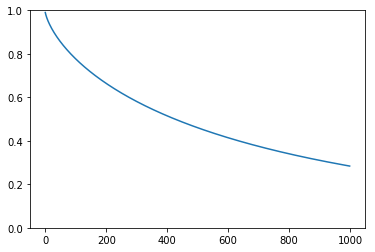

In [16]:
time = list(range(1000))
temperature = [20/(tt+1)**.7 for tt in time]
paccept = [np.exp(-0.2/temp) for temp in temperature]

plt.plot(time, paccept)
plt.ylim([0,1])
plt.show()

Armed with these choices for $C$ and $p$, we can define a `schedule(time)` function for $T(t)$:

In [17]:
def schedule(time):
    '''some sort of mapping from time to temperature, to represent how we should be 
    "cooling off" - that is, accepting wacky solutions with lower and lower probability'''
    C = 20#
    p = 0.7#
    temperature = C/(time+1)**p
    
    return temperature


### (2c)  Define our simulated annealing algorithm

Now that we have a temperature updating `schedule`, which defines how we accept/reject proposed moves for our simulated annealing algorithm, we can actually turn our pseudocode into real code!

Let's write a `simulated_annealing` algorithm. Similar to the `hill_climbing` one above, we should take as arguments only the `problem` statement and maybe one other argument for the number of iterations to run the algorithm.

In [18]:
def simulated_annealing(problem, n_iter):
    
    current = problem.initial_state
    
    for t in range(n_iter):
        temperature = problem.schedule_function(t)
        nextMove, nextValue = problem.random_move()
        delta_obj = current.value - nextValue
        #print(t, problem.current_state.node, problem.current_state.value, nextMove, nextValue, delta_obj)
        if delta_obj > 0:
            # the proposed move is an improvement, so accept w.p. 1
            problem.current_state.node, problem.current_state.value = nextMove, nextValue
        else:
            # the proposed move is worse; accept with probability exp[delta_obj/T]
            p_accept = np.exp(delta_obj/temperature)
            #print(p_accept)
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                problem.current_state.node, problem.current_state.value = nextMove, nextValue

    return problem.current_state


### (2d) Let's solve that problem from class!


You know that plot in class of an example objective function we wanted to use simulated annealing to minimize?

Well...  it's just the `several_gaussian_objective` from **(1d)** but ***upside-down!!!***

(You should feel free to rename this function...)

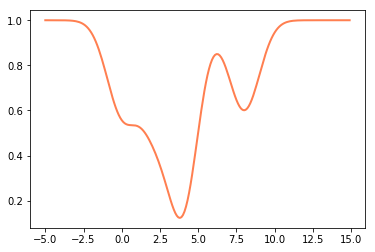

In [19]:
def not_such_a_mystery_anymore_objective(state):
    locs = [0,2.1,4,4,8] # centers of a bunch of normal distributions
    objective_value = 0
    # objective function is actually just the sum of a bunch of normal pdfs
    for loc in locs:
        objective_value += stats.norm.pdf(state, loc=loc, scale=1)
    return 1-objective_value

x = np.arange(start=-5, stop=15, step=0.1)
fx = [not_such_a_mystery_anymore_objective(xk) for xk in x]

plt.plot(x, fx, c='coral', lw=2)
plt.show()

Now we're ready to use our simulated annealing algorithm to solve this problem!
1. Define an `initial_state` and declare a relevant `problem`
2. Feed these into your simulated annealing algorithm to attempt to find the global minimum

If you're having trouble hitting the global minimum, try playing around with different values for:
* stepsize (taking tiny steps makes it harder to get out of a local minimum)
* schedule (mapping from time to temperature - if you lower the temperature slowly enough, the algorithm *will* find the global minimum with probability approaching 1)
* start with initial `state` that you know should lead into the global minimum. Once you are happy that you can reliably optimize starting from there, move away and see how you need to modify the stepsize and/or temperature schedule to keep making it to the minimum.
* try using a **random restart** range of initial states, similarly to how we tackled this problem (upside-down) using hill-climbing, and plotting a histogram of the ensemble results

In [20]:
initial = 9
initial_state = state(node=initial, value=not_such_a_mystery_anymore_objective(initial))
problem_from_class = problem_anneal(initial=initial_state, objective_function=not_such_a_mystery_anymore_objective, 
                        schedule_function=schedule, stepsize=0.2)

out = simulated_annealing(problem_from_class, n_iter=10**3)

print(out.node, out.value)

3.5999999999999996 0.13330527932605785


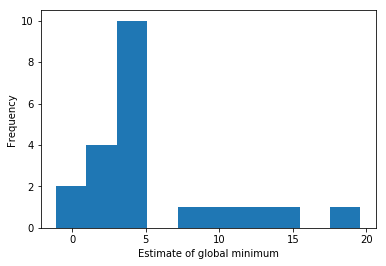

In [21]:
initial = np.arange(start=0, stop=10.5, step=0.5)
out = []
for init in initial:
    initial_state = state(node=init, value=not_such_a_mystery_anymore_objective(init))
    problem_from_class = problem_anneal(initial=initial_state, objective_function=not_such_a_mystery_anymore_objective, 
                            schedule_function=schedule, stepsize=0.2)
    out.append(simulated_annealing(problem_from_class, n_iter=10**3).node)

plt.hist(out)
plt.xlabel('Estimate of global minimum')
plt.ylabel('Frequency')
plt.show()